In [1]:
from typing import List, Tuple

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from tqdm.notebook import trange

In [2]:
class DataModule:
    def __init__(self) -> None:
        """
        Inits data module with dataset url and column names.
        """
        self.url = "http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data"
        self.column_names = [
            "mpg",
            "cylinders",
            "displacement",
            "horsepower",
            "weight",
            "acceleration",
            "model_year",
            "origin",
        ]
    def returnData(self):
        return self.dataset
    def load_data(self) -> None:
        """
        Load the dataset and drop NaN rows.
        """
        self.dataset = pd.read_csv(
            self.url,
            names=self.column_names,
            na_values="?",
            comment="\t",
            sep=" ",
            skipinitialspace=True,
        ).dropna()

    def bin_feature(self, feature: str, bins: pd.IntervalIndex) -> None:
        """
        Perform binning operation on the column named "feature" in the given
        dataframe, and encode the binned feature into one-hot vectors.

        Args:
            feature: Name of the feature to bin.
            bins: Bin intervals represented by pd.IntervalIndex.
        """
        self.dataset[feature] = pd.cut(self.dataset[feature], bins)
        self.dataset = pd.get_dummies(self.dataset, columns = [feature])

    def one_hot_encode(self, features: List[str]) -> None:
        """
        Encode a list of features in a dataframe as one-hot vectors and drop the
        (original) unencoded feature columns.

        Args:
            features: The column names of the features that need to be encoded.
        """
        self.dataset = pd.get_dummies(self.dataset, columns = features)

    def cross_feature(self, feature_a: str, feature_b: str) -> None:
        """
        Make a new crossed feature by multiplying feature_a and feature_b, and
        name the new feature as "crossed_feature".

        Args:
            feature_a: The column name of feature A.
            feature_b: The column name of feature B.
        """
        self.dataset["crossed_feature"] = self.dataset[feature_a] * self.dataset[feature_b]
        self.dataset = self.dataset.drop(columns = [feature_a, feature_b])

    def normalize(self) -> None:
        """
        Use min-max normalizaton to normalize the dataset. The equation is provided below.

        d_normalized = (d - min(d)) / (max(d) - min(d))
        """
        for i in self.dataset.columns:
            column_max = self.dataset[i].max()
            column_min = self.dataset[i].min()
            self.dataset[i] = (self.dataset[i] - column_min) / (column_max - column_min)
        

    def train_val_test_split(
        self, val_size: float = 0.2, test_size: float = 0.5, seed: int = 144
    ) -> Tuple[Tuple[np.ndarray], Tuple[np.ndarray], Tuple[np.ndarray]]:
        """
        Split a dataframe into features and labels for train, validation, and test sets.

        Args:
            val_size: The proportion of the dataset to include in the validation set.
            It must be a float type.

            test_size: The proportion of the dataset to include in the validation set. It
            must be a float type.

            seed: Controls the shuffling of the dataframe. Do not modify the default seed.

        Returns:
            A tuple containing train, validation, and test features and labels.
        """
        # ========== YOUR CODE STARTS HERE ==========
        train_split,test_split = train_test_split(self.dataset, test_size = test_size, random_state = seed, shuffle=True)
        train_split,val_split = train_test_split(train_split, test_size = val_size, random_state = seed, shuffle=True)

        x_test = test_split.iloc[:,1:]
        y_test = test_split.iloc[:, 0]

        x_train = train_split.iloc[:, 1:]
        y_train = train_split.iloc[:,0]

        x_val = val_split.iloc[:, 1:]
        y_val = val_split.iloc[:, 0]


        # ========== YOUR CODE ENDS HERE ==========

        return (
            (x_train, y_train),
            (x_val, y_val),
            (x_test, y_test),
        )

In [3]:
# Create data module
datamodule = DataModule()
datamodule.load_data()
feature_to_bin = "model_year"
features_to_encode = ["cylinders", "origin"]
features_to_cross = ["displacement", "acceleration"]
intervals = pd.IntervalIndex.from_tuples([(69, 74), (74, 79), (79, 84)])


datamodule.bin_feature(feature_to_bin, intervals)
datamodule.one_hot_encode(features_to_encode)
datamodule.cross_feature(features_to_cross[0], features_to_cross[1])
datamodule.normalize()
datamodule.train_val_test_split()
#datamodule.dataset

((     horsepower    weight  model_year_(69, 74]  model_year_(74, 79]  \
  274    0.309783  0.345052                  0.0                  1.0   
  146    0.157609  0.145166                  1.0                  0.0   
  130    0.184783  0.237596                  1.0                  0.0   
  341    0.347826  0.315282                  0.0                  0.0   
  80     0.217391  0.221718                  1.0                  0.0   
  ..          ...       ...                  ...                  ...   
  213    0.538043  0.692373                  0.0                  1.0   
  53     0.103261  0.045364                  1.0                  0.0   
  187    0.510870  0.737737                  0.0                  1.0   
  98     0.293478  0.472073                  1.0                  0.0   
  16     0.277174  0.329175                  1.0                  0.0   
  
       model_year_(79, 84]  cylinders_3  cylinders_4  cylinders_5  cylinders_6  \
  274                  0.0          0.0

In [4]:
class LinearRegressionTrainer:
    def __init__(
        self, num_features: int, learning_rate: float = 1e-3, num_epochs: int = 5000
    ) -> None:
        """
        Inits the linear regression model.
        """
        self.learning_rate = learning_rate
        self.num_epochs = num_epochs
        self.num_features = num_features
        self.train_loss_history = []
        self.val_loss_history = []
        self.test_loss = None

        self.theta = np.zeros(shape = self.num_features + 1)

    def gradient_descent_step(self, x: np.ndarray, y: np.ndarray) -> None:
        """
        Perform a single step of gradient update on self.theta.

        Args:
            x: A matrix of features.
            y: A vector of labels.
        """
        self.theta = self.theta - (self.learning_rate/y.shape[0]) * self.mse_loss_derivative(x,y)

    def train(
        self,
        x_train: np.ndarray,
        y_train: np.ndarray,
        x_val: np.ndarray,
        y_val: np.ndarray,
    ) -> None:
        """
        Run gradient descent for n epochs, where n = self.num_epochs.

        Args:
            x: A matrix of features.
            y: A vector of labels.
        """
        x_train = np.concatenate((np.ones((x_train.shape[0], 1)), x_train),axis = 1)
        x_val = np.concatenate((np.ones((x_val.shape[0], 1)), x_val), axis = 1)
        m = y_train.shape[0]
        for i in range(self.num_epochs):
            self.train_loss_history.append((np.sum((x_train @ self.theta - y_train)**2))/2/m)
            self.val_loss_history.append((np.sum((x_val @ self.theta - y_val)**2))/2/m)
            self.gradient_descent_step(x_train, y_train)
    def mse_loss_derivative(self, x: np.ndarray, y: np.ndarray) -> np.ndarray:
        """
        Calculates the derivative of the loss function w.r.t. theta.

        Args:
            x: A matrix of features.
            y: A vector of labels.

        Returns:
            A vector with the same dimension as theta, where each element is the
            partial derivative of the loss function w.r.t. the corresponding element
            in theta.
        """
        return (x.T.dot((x @ self.theta - y)))

    def evaluate(self, x_test: np.ndarray, y_test: np.ndarray) -> None:
        """
        Evaluate the model on test set and store the test loss int self.test_loss.

        Args:
            x_test: A matrix of features.
            y_test: A vector of labels.
        """
        m = y_test.shape[0]
        x_test = np.concatenate((np.ones((x_test.shape[0], 1)), x_test),axis = 1)
        self.test_loss = (np.sum((x_test @ self.theta - y_test)**2))/2/m

    def mse_loss(pred: np.ndarray, target: np.ndarray) -> float:
        """
        Calculate the mean squared error given prediction and target. The equation is
        given below.

        mse = sum((pred - target) ^ 2) / (2 * n)

        Args:
            pred: A vector of predictions.
            target: A vector of labels.

        Returns:
            Mean squared error between each element in pred and target.
        """
        assert pred.shape == target.shape
        m = pred.shape[0]
        #print(m)
        cost = (np.sum((X @ theta - y)**2))/2/m
        return cost

Final train loss: 0.026823521619587752
Final validation loss: 0.005516032134163176
[0.11327847 0.01857359 0.0237478  0.02529734 0.03925044 0.04873069
 0.00190088 0.09001489 0.00348683 0.0164694  0.00140647 0.03476207
 0.03306152 0.04545489 0.0224919 ]


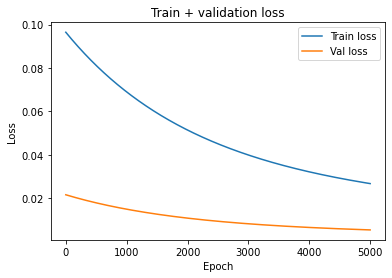

Test loss: 0.022913972513771263


In [5]:
learning_rate = 0.0001
iterations = 5000
train, val, test = datamodule.train_val_test_split()

X_train = train[0]
y_train = train[1]
trainer = LinearRegressionTrainer(X_train.shape[1] , learning_rate, iterations)

X_val = val[0]
y_val = val[1]

trainer.train(X_train, y_train, X_val, y_val)


print(f"Final train loss: {trainer.train_loss_history[-1]}")
print(f"Final validation loss: {trainer.val_loss_history[-1]}")
print(trainer.theta)

plt.plot(np.arange(trainer.num_epochs), trainer.train_loss_history, label="Train loss")
plt.plot(np.arange(trainer.num_epochs), trainer.val_loss_history, label="Val loss")
plt.title("Train + validation loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

x_test = test[0]
y_test = test[1]
trainer.evaluate(x_test, y_test)
print(f"Test loss: {trainer.test_loss}")

